# Introduction

I found this dataset in the UC Irvine Machine Learning Repository:

https://archive-beta.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

This database was built from the recordings of 30 subjects performing activities of daily living while carrying a waist-mounted smartphone with embedded inertial sensors.

## Summary of the data
* The experiments have been carried out with a group of 30 volunteers within an 
age bracket of 19-48 years.
* Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone around their waist.
* Using its embedded accelerometer and gyroscope, recordings were made of 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz.
* The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window).
* The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity.
* The dataset has been randomly partitioned into two sets, where 21 of the volunteers was selected for generating the training data and 9 for the test data, i.e. 70-30 split.
* The data is stored in separate 'train' and 'test' folders.

## Objective
The idea is to classify the activities by modelling the time series data. To this end we will try different recurrent neural network to see how they compare.

## Disclaimer
Sections 'Preprocessing' and 'Exploratory data analysis' have been adapted from https://machinelearningmastery.com/


My goal is to learn and explore my own model variants in section 'Modelling'.

# Getting started

First things first. Let's import the libraries and set the path.

In [1]:
import numpy as np
import pandas as pd
import random
from numpy import mean
from numpy import std
from numpy import array
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot
from math import ceil, floor

In [2]:
path_main = '/content/drive/MyDrive/Data/UCI_HAR_Dataset/'
path_train = path_main + 'train/Inertial_Signals/'
path_test = path_main + 'test/Inertial_Signals/'

# Preprocessing

The data in the train and test folders is stored in 9 different files:
* Three files (one for each axis) with total acceleration values.
* Three files (one for each axis) with body acceleration values.
* Three files (one for each axis) with angular velocity values.

These need to be combined in a way suitable for multivariate time series modeling. We know that for sequence modelling the shape of input data needs to be in three dimensional form of (#samples, timesteps, #features). We will try to achieve that below with data from every being turned into a feature, i.e. a total of 9 features.

First, let's create a function to read the individual files.

In [4]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

In [9]:
data = load_file(path_train+'total_acc_x_train.txt')
print(data.shape)

(7352, 128)


Let us create a function to combine multiple files into one.

In [10]:
# load a list of files, such as x, y, z axes data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

Now let's combine data of one kind for the x, y & z axes.

In [11]:
# load the total acc data
filenames = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
total_acc = load_group(filenames, prefix=path_train)
print(total_acc.shape)

(7352, 128, 3)


Finally, combining them all.

In [12]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial_Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

Now, let's load and have a look at them.

In [13]:
# load all train
X_train, y_train = load_dataset_group('train', path_main)
print(X_train.shape, y_train.shape)
# load all test
X_test, y_test = load_dataset_group('test', path_main)
print(X_test.shape, y_test.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


# Exploratory data analysis

To begin with let's check if the dataset is evenly distributed for the different classes of activities to be labeled.

In [14]:
# summarize the balance of classes in an output variable column
def class_breakdown(data):
	# convert the numpy array into a dataframe
	df = pd.DataFrame(data)
	# group data by the class value and calculate the number of rows
	counts = df.groupby(0).size()
	# retrieve raw rows
	counts = counts.values
	# summarize
	for i in range(len(counts)):
		percent = counts[i] / len(df) * 100
		print('Class=%d, total=%d (%.2f%%)' % (i+1, counts[i], percent))

In [15]:
# summarize class breakdown
print('Train Dataset')
class_breakdown(y_train)

Train Dataset
Class=1, total=1226 (16.68%)
Class=2, total=1073 (14.59%)
Class=3, total=986 (13.41%)
Class=4, total=1286 (17.49%)
Class=5, total=1374 (18.69%)
Class=6, total=1407 (19.14%)


In [16]:
# summarize class breakdown
print('Test Dataset')
class_breakdown(y_test)

Test Dataset
Class=1, total=496 (16.83%)
Class=2, total=471 (15.98%)
Class=3, total=420 (14.25%)
Class=4, total=491 (16.66%)
Class=5, total=532 (18.05%)
Class=6, total=537 (18.22%)


This is great. Both the training and testing datasets are evenly distributed for the 6 classes of activity. Now let's look at the subject ids for the training and testing datasets. The subject_train.txt and subject_test.txt files help us relate the training and testing data to the subjects. This is not really relevant for the activity prediction model, of course, as the prediction is made independent of the human involved.

In [17]:
train_sub_map = load_file(path_main+'train/subject_train.txt')
test_sub_map = load_file(path_main+'test/subject_test.txt')
train_subjects = unique(train_sub_map)
test_subjects = unique(test_sub_map)
print('Train subjects:\n',train_subjects)
print('\nTest subjects:\n',test_subjects)

Train subjects:
 [ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]

Test subjects:
 [ 2  4  9 10 12 13 18 20 24]


We'd like to see a line plot of the time series data for all the 9 features for any given subject. Let's write some functions for that.

First, we'll have to pick out data that belongs to any one given subject.

In [18]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
	# get row indexes for the subject id
	ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
	# return the selected samples
	return X[ix, :, :], y[ix]

Next, we delete the 50% overlap that has been introduced in the data.

In [19]:
# convert a series of windows to a 1D list
def to_series(windows):
	series = list()
	for window in windows:
		# remove the overlap from the window
		half = int(len(window) / 2) - 1
		for value in window[-half:]:
			series.append(value)
	return series

In [20]:
# plot the data for one subject
def plot_subject(X, y):
	fig=pyplot.figure()
	fig.set_figheight(15)
	fig.set_figwidth(10)
	# determine the total number of plots
	n, off = X.shape[2] + 1, 0
	# plot total acc
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.xticks([])
		pyplot.title('total acc '+str(i), y=0, loc='left')
		off += 1
	# plot body acc
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.xticks([])
		pyplot.title('body acc '+str(i), y=0, loc='left')
		off += 1
	# plot body gyro
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.xticks([])
		pyplot.title('body gyro '+str(i), y=0, loc='left')
		off += 1
	# plot activities
	pyplot.subplot(n, 1, n)
	pyplot.plot(y)
	pyplot.title('activity', y=0, loc='left')
	pyplot.show()

The chosen subject is:  5
The shapes of the data are:  (302, 128, 9) (302, 1)


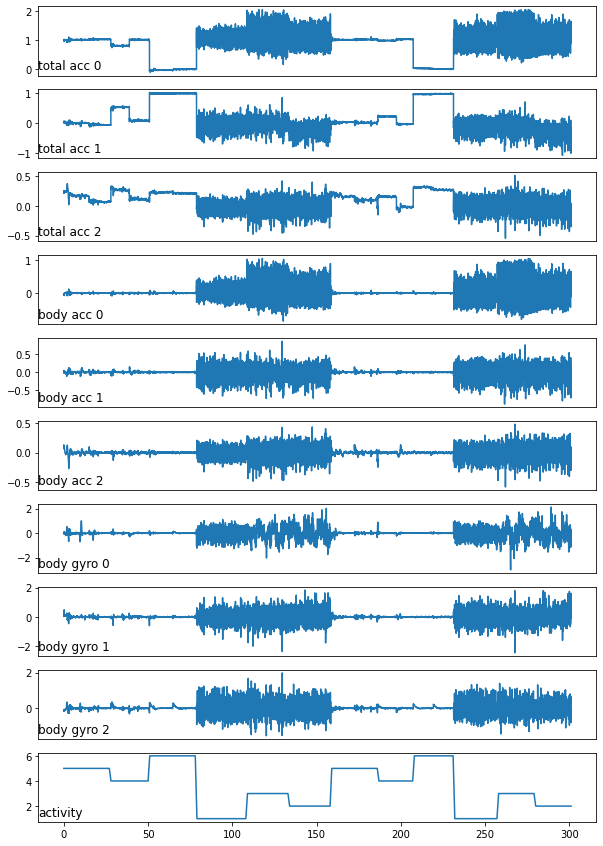


(1: WALKING, 2: WALKING_UPSTAIRS, 3: WALKING_DOWNSTAIRS, 4: SITTING, 5: STANDING, 6: LAYING)


In [21]:
# get the data for one subject
sub_id = train_subjects[random.randint(0, len(train_subjects))]
subX, suby = data_for_subject(X_train, y_train, train_sub_map, sub_id)
print('The chosen subject is: ',sub_id)
print('The shapes of the data are: ', subX.shape, suby.shape)
# plot data for subject
plot_subject(subX, suby)
print('\n(1: WALKING, 2: WALKING_UPSTAIRS, 3: WALKING_DOWNSTAIRS, 4: SITTING, 5: STANDING, 6: LAYING)')

# Modelling

Now let's get to the most exciting part. I'd like to try the following variants:


1. Single layer of simple RNN
2. Single layer of LSTM
3. Single layer of bidirectional LSTM
4. Two layers of stacked LSTM
5. Single layer of GRU
6. Two layers of stacked GRU

Let's import all the libraries first.



In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, ConvLSTM2D, GRU, Bidirectional
from tensorflow.keras.utils import to_categorical

In [23]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	X_train, y_train = load_dataset_group('train', prefix + path_main)
	print(X_train.shape, y_train.shape)
	# load all test
	X_test, y_test = load_dataset_group('test', prefix + path_main)
	print(X_test.shape, y_test.shape)
	# zero-offset class values
	y_train = y_train - 1
	y_test = y_test - 1
	# one hot encode y
	y_train = to_categorical(y_train)
	y_test = to_categorical(y_test)
	print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
	return X_train, y_train, X_test, y_test

In [24]:
# load data
X_train, y_train, X_test, y_test = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


## Simple RNN
First let's try a simple RNN.

In [28]:
# fit and evaluate a simple RNN model
def evaluate_rnn_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(SimpleRNN(200, input_shape=(n_timesteps,n_features)))
	model.add(Dense(200, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [29]:
acc_rnn = evaluate_rnn_model(X_train, y_train, X_test, y_test)
print('Accuracy with a simple RNN model: %.2f' % (acc_rnn*100))

Accuracy with a simple RNN model: 77.23


This is a poor result.

## Long Short-Term Memory (LSTM)
Now let's try the most popular LSTM. I'll add a dropout of 20% before the dense layer.

In [35]:
# fit and evaluate an LSTM model
def evaluate_lstm_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(LSTM(200, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.2))
	model.add(Dense(200, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [36]:
acc_lstm = evaluate_lstm_model(X_train, y_train, X_test, y_test)
print('Accuracy with LSTM model: %.2f' % (acc_lstm*100))

Accuracy with LSTM model: 90.53


That's a huge improvement over the simple RNN.

## Bidirectional LSTM
Now let's see if a bidirectional LSTM can fare any better.

In [38]:
# fit and evaluate a bidirectional LSTM model
def evaluate_bidir_lstm_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(Bidirectional(LSTM(200, input_shape=(n_timesteps,n_features))))
	model.add(Dropout(0.2))
	model.add(Dense(200, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [39]:
acc_bidir = evaluate_bidir_lstm_model(X_train, y_train, X_test, y_test)
print('Accuracy with bidirectional LSTM model: %.2f' % (acc_bidir*100))

Accuracy with bidirectional LSTM model: 92.16


There is clearly an improvement thanks to the bidirectional cell states.

## Stacked LSTM
Let's see what happens when we stack them.

In [46]:
# fit and evaluate a stacked LSTM model
def evaluate_bidir_stack_lstm_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(LSTM(150, return_sequences=True, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.1))
	model.add(LSTM(150))
	model.add(Dropout(0.1))
	model.add(Dense(150, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [47]:
acc_stack_lstm = evaluate_bidir_stack_lstm_model(X_train, y_train, X_test, y_test)
print('Accuracy with stacked bidirectional LSTM model: %.2f' % (acc_stack_lstm*100))

Accuracy with stacked bidirectional LSTM model: 91.04


Ok, not much improvement there.

## Gated recurrent unit (GRU)
Now let's try a GRU.

In [48]:
# fit and evaluate a GRU model
def evaluate_gru_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(GRU(200, input_shape=(n_timesteps,n_features)))
	model.add(Dense(75, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [49]:
acc_gru = evaluate_gru_model(X_train, y_train, X_test, y_test)
print('Accuracy with GRU model: %.2f' % (acc_gru*100))

Accuracy with GRU model: 91.79


In [51]:
# fit and evaluate a stacked GRU model
def evaluate_stack_gru_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(GRU(200, return_sequences=True, input_shape=(n_timesteps,n_features)))
	model.add(GRU(200))
	model.add(Dense(150, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [52]:
acc_stack_gru = evaluate_stack_gru_model(X_train, y_train, X_test, y_test)
print('Accuracy with stacked GRU model: %.2f' % (acc_stack_gru*100))

Accuracy with stacked GRU model: 91.58


# Conclusion
Looks like the accuracies hit a ceiling around 92%.